# imports

In [531]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import glob
import os
import pickle
import pandas as pd
import matplotlib
import random
import seaborn as sns

from NDNT import NDN
import NDNT.utils as utils # some other utilities
import ColorDataUtils.mattprintlib as mprint
import ColorDataUtils.mattplotlib as mplt
from ColorDataUtils.multidata_utils import MultiExperiment

class Model:
    def __init__(self):
        pass
#from models import iter_core, cnn_core

device = torch.device("cuda:1")

datadir = '/Users/matt/projects/umd/cdata/'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

In [532]:
expts = MultiExperiment(names=['J220715', 'J220722', 'J220707', 'J220801'],
                        datadir=datadir,
                        num_lags=16,
                        et_metric_thresh=0.8,
                        array_types=['UT', 'UT', 'UT', 'UT'],
                        luminance_only=True)

  FILE_INFO: stim_locsLP list again -- ok but output check
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
598080 total time steps, 882 units
J220715 68.5% fixations remaining
J220722 64.8% fixations remaining
J220707 65.3% fixations remaining
J220801 66.8% fixations remaining


# load core model

In [533]:
expt_names = ['J220715', 'J220722', 'J220707', 'J220801']
expt_LLses = []
# load core model
path = '../../../ori_sfn/core/'
filename = path+'model_rotated_frozenb_3'
with open(filename+'.pkl', 'rb') as f:
    model = pickle.load(f)
with open(filename+'.npy', 'rb') as f:
    LLs = np.load(f)
for e, expt in enumerate(expt_names):
    start,end = expts.experiment_boundaries[e]
    expt_LLs = np.mean(LLs[start:end])
    expt_LLses.append(expt_LLs)

np.mean(LLs), expt_LLses

(0.031472683, [0.031140815, 0.028908366, 0.020384764, 0.04534133])

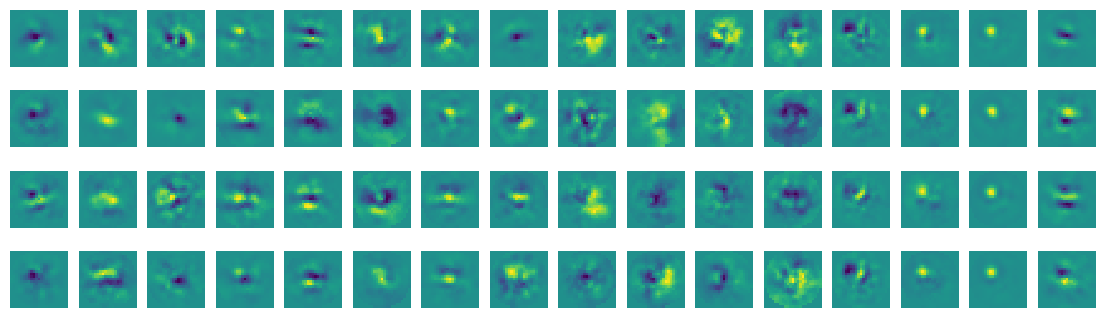

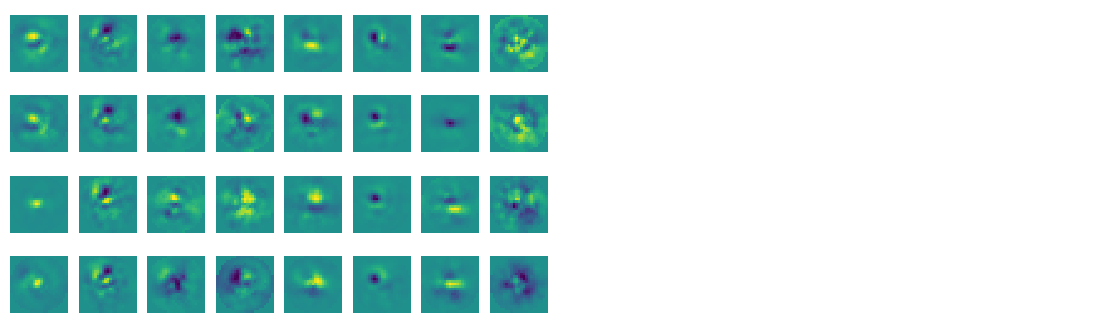

In [534]:
mplt.plot_proj_filters(model)

# get readouts

In [535]:
class Layer:
    def __init__(self, indexes, weights, orientation):
        self.indexes = indexes
        self.weights = weights
        self.orientation = orientation
        
class Cell:
    def __init__(self, index, layers, orientations=6):
        self.index = index
        self.orientation_to_readout = {}
        for orientation in range(orientations):
            self.orientation_to_readout[orientation] = np.concatenate([layer.weights[:, index] for layer in layers if layer.orientation == orientation], axis=0)

(288, 598)
(24, 598)
(24, 598)
(24, 598)
(24, 598)
(24, 598)
(24, 598)
(16, 598)
(16, 598)
(16, 598)
(16, 598)
(16, 598)
(16, 598)
(8, 598)
(8, 598)
(8, 598)
(8, 598)
(8, 598)
(8, 598)
18 19
(288, 598)


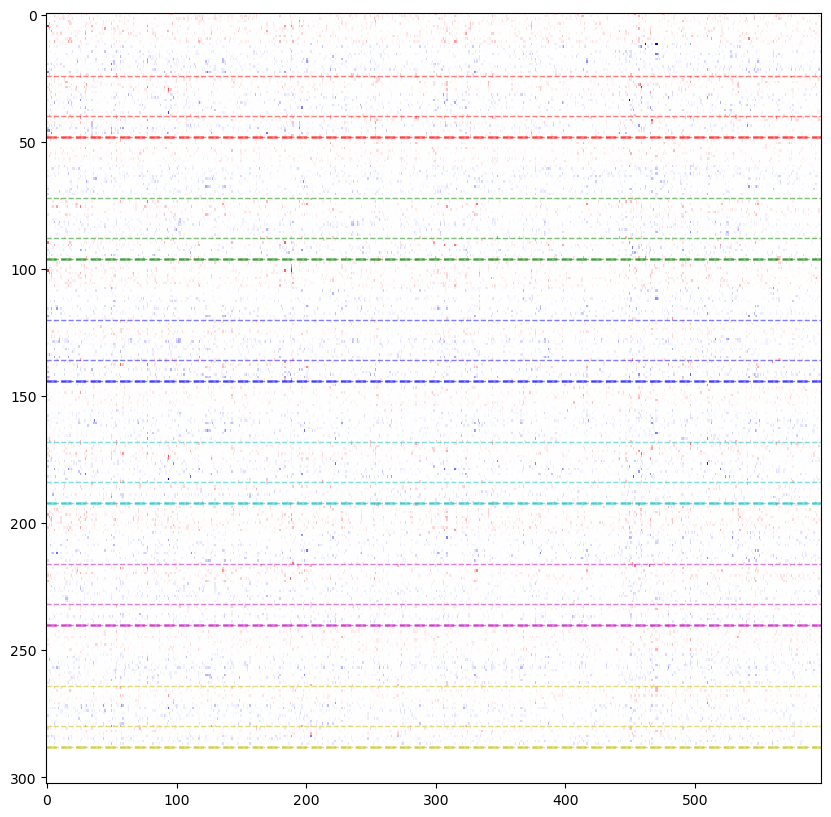

In [536]:
layer_num_inhs, layer_heights, layer_bounds, readout_weights = mplt.get_readout_weights(model, group_orientations=True)
print(readout_weights.shape)

# 6 orientations per layer, and we have 24 layers
# we need to grab the first, then the 7th, then the 13th, etc.
# and rearrange the weights so that they are interleaved, like this

# create list of Layer objects from the readout weights
layers = []
orientation = 0
for bound in range(1, len(layer_bounds)):
    if bound == 0:
        indexes = np.arange(layer_bounds[bound])
    else:
        indexes = np.arange(layer_bounds[bound-1], layer_bounds[bound])
    weights = readout_weights[indexes, :]
    print(weights.shape)
    layers.append(Layer(indexes, weights, orientation))
    orientation += 1
    if orientation == 6:
        orientation = 0

# rearrange the layers by orientation
print(len(layers), len(layer_bounds))
orientation_to_layer = {}
for layer in layers:
    orientation = layer.orientation
    if orientation not in orientation_to_layer:
        orientation_to_layer[orientation] = []
    orientation_to_layer[orientation].append(layer)
    
layers = []
for orientation in range(6):
    layers.extend(orientation_to_layer[orientation])

# convert the list of layers back to a numpy array
readout_weights = np.concatenate([layer.weights for layer in layers], axis=0)
print(readout_weights.shape)

fig = plt.figure(figsize=(10,10))
vmax = readout_weights.max()
plt.imshow(readout_weights, cmap='bwr', aspect='auto', vmin=-vmax, vmax=vmax, interpolation='none')

# plot the layer boundaries
bound = 0
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for orientation in orientation_to_layer.keys():
    for layer in orientation_to_layer[orientation]:
        bound += layer.indexes[-1] - layer.indexes[0]+1
        plt.axhline(bound, color=colors[orientation], linewidth=1, linestyle='--', alpha=0.5)
    else:
        plt.axhline(bound, color=colors[orientation], linewidth=2, linestyle='--', alpha=0.5)

# cells list

In [537]:
# populate the cells list
cells = []
for i in range(readout_weights.shape[1]):
    cells.append(Cell(i, layers))
    
# for cell in cells:
#     print(cell.orientation_to_readout[0].shape)
#     print(cell.orientation_to_readout[1].shape)

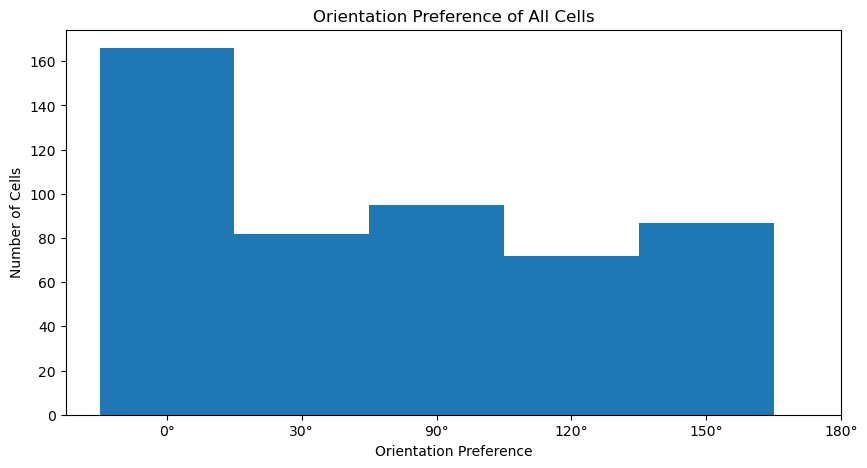

In [538]:
# cluster cells by their orientation preference

# make a histogram by the orientation preference of each cell
# based on the orientation with the maximum readout weights (absolute value) for that cell

# get the orientation preference of each cell
orientation_preferences = []
for cell in cells:
    orientation_to_readout = cell.orientation_to_readout
    max_orientation = 0
    max_readout = 0
    for orientation in orientation_to_readout.keys():
        readout = orientation_to_readout[orientation]
        sum_readout = np.sum(np.abs(readout))
        if sum_readout > max_readout:
            max_readout = sum_readout
            max_orientation = orientation
    orientation_preferences.append(max_orientation)
    
# make a histogram of the orientation preferences
fig = plt.figure(figsize=(10,5))
plt.hist(orientation_preferences, bins=np.arange(6)-0.5)
plt.xlabel('Orientation Preference')
plt.ylabel('Number of Cells')
plt.title('Orientation Preference of All Cells')
# label the x-axis by angle (0, 30, 90, 120, 150, 180)
plt.xticks([0, 1, 2, 3, 4, 5], ['0°', '30°', '90°', '120°', '150°', '180°'])
plt.show()

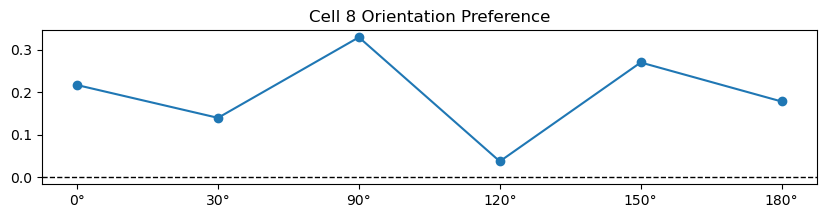

In [539]:
# for a cell plot the total abs values for each orientation
from ColorDataUtils import RFutils

def ori_pref(cell):
    orientation_to_readout = cells[cell].orientation_to_readout
    sum_readouts = []
    max_sum_readout = 0
    for orientation in orientation_to_readout.keys():
        readout = orientation_to_readout[orientation]
        sum_readout = np.sum(np.abs(readout))
        sum_readouts.append(sum_readout)
        if sum_readout > max_sum_readout:
            max_sum_readout = sum_readout
            max_orientation = orientation
    return sum_readouts, max_orientation

cell = 8

fig = plt.figure(figsize=(10,2))
plt.plot(np.arange(6), ori_pref(cell)[0], 'o-')
# label the x-axis by angle (0, 30, 90, 120, 150, 180)
plt.axhline(0, color='k', linewidth=1, linestyle='--')
plt.xticks([0, 1, 2, 3, 4, 5], ['0°', '30°', '90°', '120°', '150°', '180°'])
plt.title(f'Cell {cell} Orientation Preference')
plt.show()

#fname = f'/Users/matt/projects/umd/gqms/J220715/LUMmodels/UT{cell:03}gqmwET.pkl'
#with open(fname, 'rb') as f:
#    gqm = pickle.load(f)
#max_dir_score, max_dir_score_angle, max_motion_im = RFutils.GQM_direction(gqm, lin_net=0, quad_net=2)
#print(max_dir_score_angle+90)
#mplt.plot_gqm(gqm)

# PLOTS

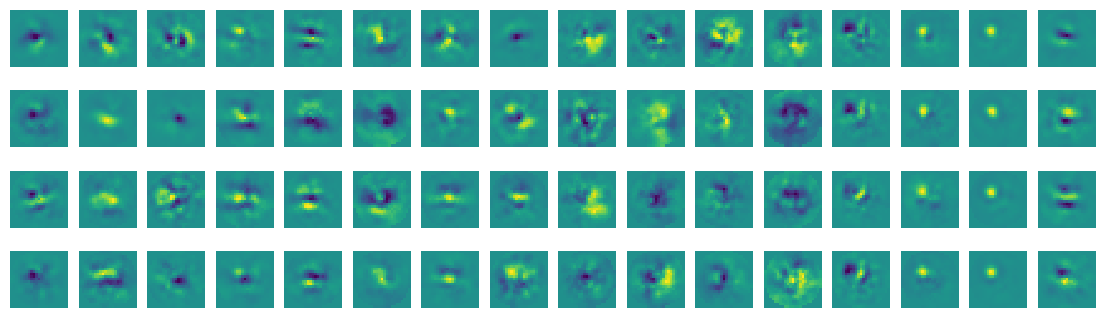

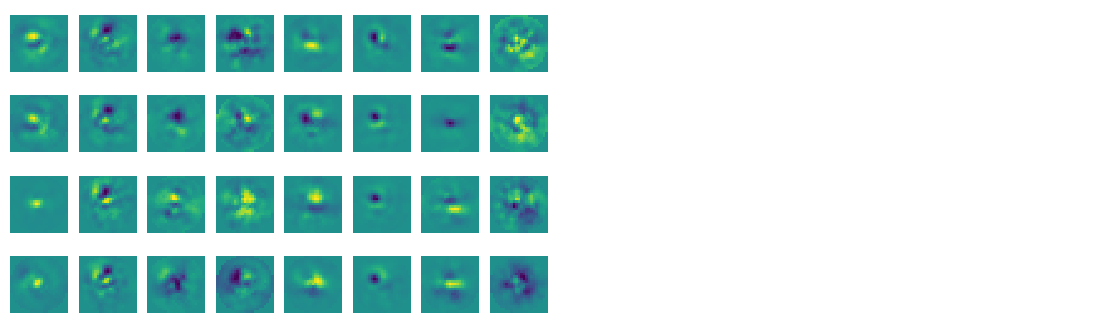

In [540]:
mplt.plot_proj_filters(model)

# orientation by barcode

In [541]:
channel_cells, channel_map = mplt.get_channel_cells(expts)
print(channel_map.shape)
print(len(channel_cells.keys()), channel_cells.keys())

(598,)
92 dict_keys([160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255])


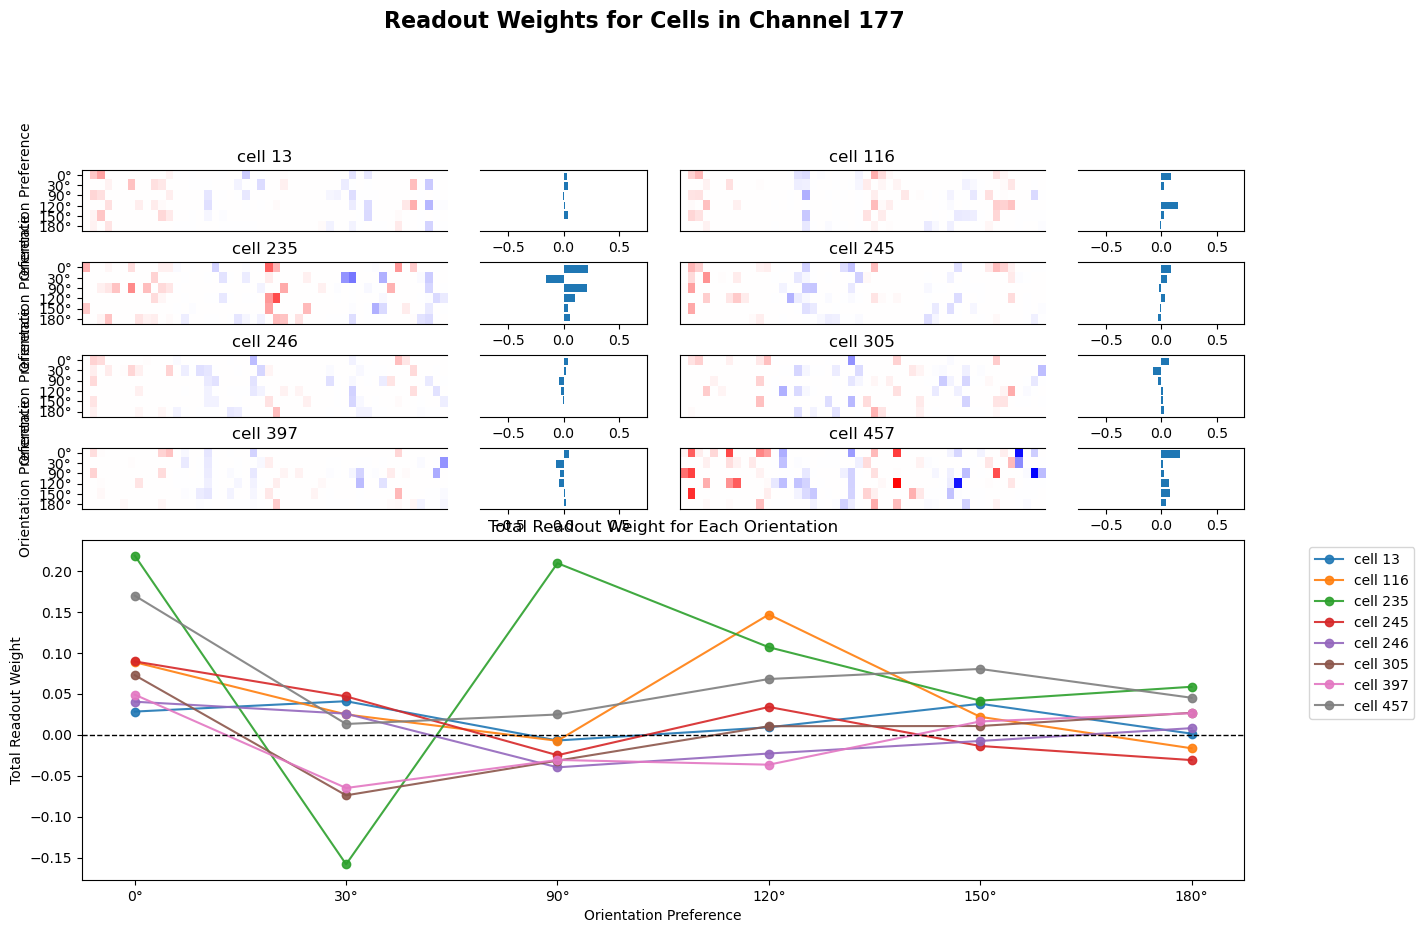

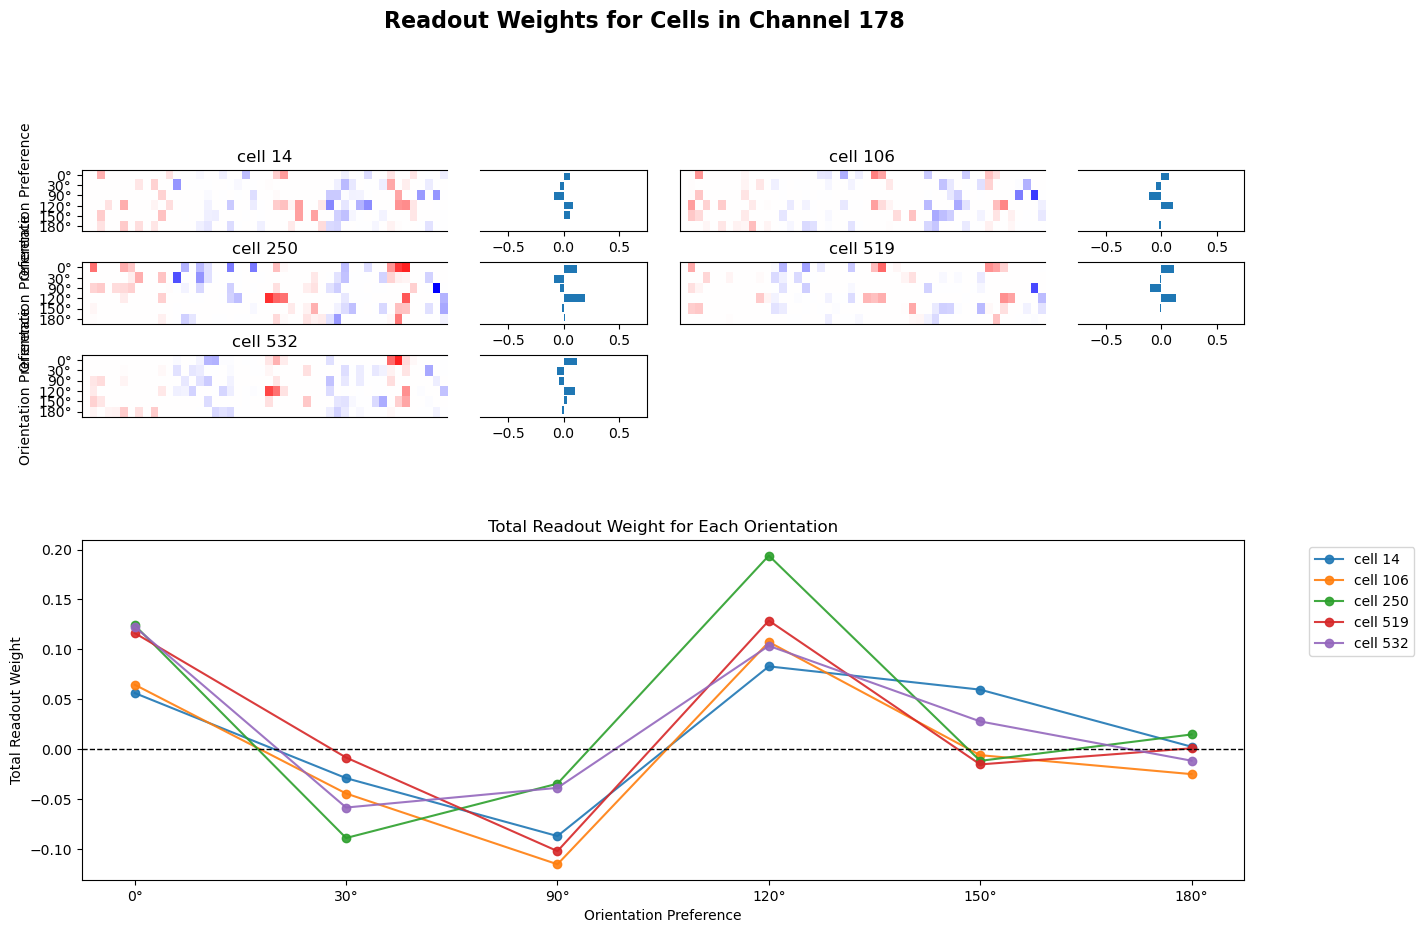

KeyboardInterrupt: 

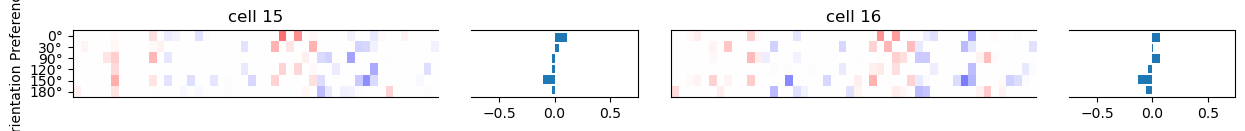

In [542]:
for channel in list(channel_cells.keys())[15:30]:
    fig = plt.figure(figsize=(15,10))
    rows,cols = 8,6
    grid = matplotlib.gridspec.GridSpec(rows, cols, wspace=0.2, hspace=0.5)
    # readout for cells:
    readouts = []
    for cc, cell in enumerate(channel_cells[channel]):
        for orientation in range(6):
            readout = cells[cell].orientation_to_readout[orientation]
            readouts.append(readout)
    readouts = np.array(readouts)
    vmax = np.max(np.abs(readouts))
    row = 0
    col = 0
    ch_cells = channel_cells[channel]
    barcodes = {}
    barcode_sums = {}
    for cc, cell in enumerate(ch_cells):
        # plot the readout weights for each orientation
        barcode = np.zeros((6, 48))
        for orientation in range(6):
            barcode[orientation, :] = cells[cell].orientation_to_readout[orientation]
        barcodes[cell] = barcode
        barcode_sum = np.sum(barcode, axis=1)
        barcode_sums[cell] = barcode_sum

    for cc, cell in enumerate(ch_cells[:8]):
        ax = plt.subplot(grid[row, col:col+2])
        ax.imshow(barcodes[cell], cmap='bwr', aspect='auto', vmin=-vmax, vmax=vmax, interpolation='none')
        # change the y-axis to be the orientation preference
        if col == 0:
            ax.set_yticks([0, 1, 2, 3, 4, 5], ['0°', '30°', '90°', '120°', '150°', '180°'])
            ax.set_ylabel('Orientation Preference')
            ax.set_xticks([])
        else:
            # turn off tickmarks
            ax.set_yticks([])
            ax.set_xticks([])
        ax.set_title(f'cell {cell}')

        ax.spines['right'].set_visible(False)

        # plot the totals of each row next the plot rotated on the y-axis
        ax2 = plt.subplot(grid[row, col+2])
        ax2.barh(np.arange(6), barcode_sums[cell], alpha=1)
        ax2.spines['left'].set_visible(False)
        ax2.set_yticks([])
        ax2.invert_yaxis() # to flip rightside up
        # set max and min to vmax and -vmax
        ax2.set_xlim(-0.75, 0.75)
        
        # set axis colorbar
        #cbar = plt.colorbar(ax=ax, shrink=0.5)
        if col == 3:
            row += 1
            col = 0
        else:
            col += 3
    
    # plot the barcode sums for each cell
    # overlapping at the bottom row across the whole row
    ax3 = plt.subplot(grid[4:, :])
    # plot the barcode sums for each cell
    # in a stacked bar chart
    df = {}
    for ch_cell in ch_cells:
        barcode_sum = barcode_sums[ch_cell]
        df['cell ' + str(ch_cell)] = [barcode_sum[i] for i in range(6)]
    df = pd.DataFrame(df, index=['0°', '30°', '90°', '120°', '150°', '180°'])
    df.plot.line(ax=ax3, legend=True, marker='o', alpha=0.9)
    # put legend outside of plot
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # draw zero line
    ax3.axhline(0, color='black', linewidth=1, linestyle='--')
    ax3.set_ylabel('Total Readout Weight')
    ax3.set_xlabel('Orientation Preference')
    ax3.set_title('Total Readout Weight for Each Orientation')
    
    plt.suptitle(f'Readout Weights for Cells in Channel {channel}',
                fontsize=16, fontweight='bold')
    # shift the subplots down to make room for the suptitle
    plt.subplots_adjust(top=0.82)
    plt.show()

# barcode refactoring

In [ ]:
layer_num_inhs, layer_heights, layer_bounds, readout_weights = mplt.get_readout_weights(model, group_orientations=True)
layer_bounds

array([  0,  24,  48,  72,  96, 120, 144, 160, 176, 192, 208, 224, 240,
       248, 256, 264, 272, 280, 288])

In [ ]:
me = mplt.MultiElectrode(model, expts)

In [ ]:
me.cells[0].channel_index

160

In [ ]:
# get the list of Channel objects
channels = mplt.extract_channels(model, expts)
# get the first channel
channel = channels[0]
plt.imshow(channel.dist_matrix())
plt.show()
print(channel.dists())
cell = channel.cells[0]
#cell.ori_readouts()
ori_pref = cell.ori_pref()
print(ori_pref)
#cell.plot_ori_readouts()


cell_map = {}
for channel in channels:
    for cell in channel.cells:
        cell_map[cell.index] = cell

cell_map[10].plot_ori_pref(abs=True)
cell_map[10].plot_ori_pref()
cell_map[8].plot_ori_pref(abs=True)
cell_map[8].plot_ori_pref()

print(cell_map[8].dist(cell_map[8]))
print(cell_map[10].dist(cell_map[10]))
print(cell_map[8].dist(cell_map[10]))

# cell.readout.readout_df[(cell.readout.readout_df['orientation'] == 2) &
#                         (cell.readout.readout_df['layer'] == 0) & 
#                         (cell.readout.readout_df['type'] == 'all')]['vector'].values

AttributeError: module 'ColorDataUtils.mattplotlib' has no attribute 'extract_channels'

# distance histograms

In [ ]:
within_channel_cell_dists = []
for channel in channels:
    cell_dists = channel.cell_dist_list()
    within_channel_cell_dists.append(cell_dists)

In [ ]:
import tqdm
across_channel_cell_dists = []
for channel1 in tqdm.tqdm(channels):
    for channel2 in channels:
        dist_matrix = np.zeros((len(channel1.cells), len(channel2.cells)))
        for i, cell1 in enumerate(channel1.cells):
            for j, cell2 in enumerate(channel2.cells):
                if i <= j: # only calculate the lower triangle
                    continue
                dist_matrix[i,j] = cell1.dist(cell2)[0]
        across_channel_cell_dists.extend(dist_matrix[dist_matrix.nonzero()].flatten())

100%|██████████| 92/92 [00:23<00:00,  3.91it/s]


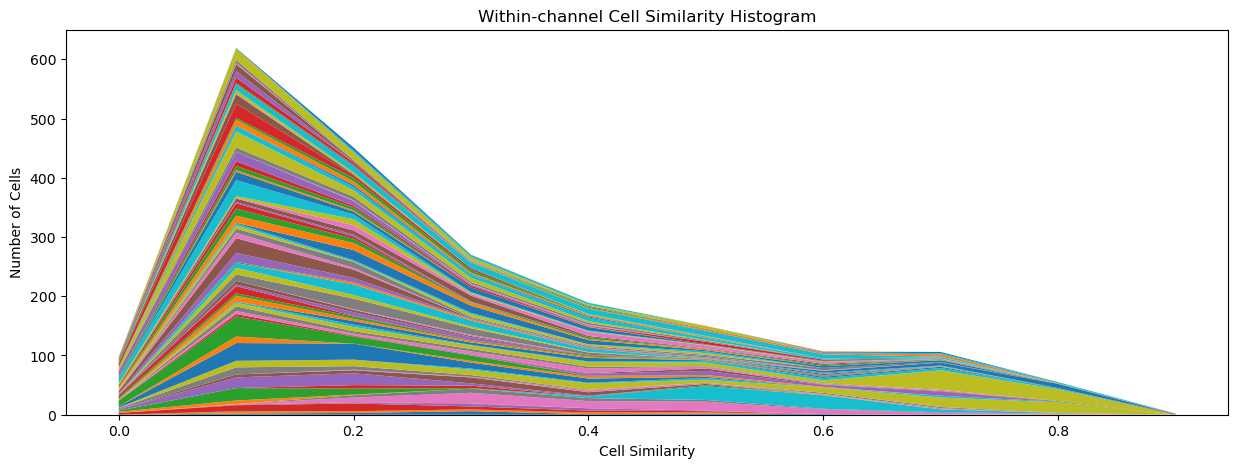

In [ ]:
# plot the histogram of cell distances
fig = plt.figure(figsize=(15,5))
hists = []
for chidx, cell_dists in enumerate(within_channel_cell_dists):
    # plot stacked area histogram
    hist = np.histogram(cell_dists, bins=np.arange(0, 1.1, 0.1))[0]
    hists.append(hist)
plt.stackplot(np.arange(0, 1, 0.1), *hists, labels=[f'channel {chidx}' for chidx in range(len(channels))])

#hist = np.histogram(across_channel_cell_dists, bins=np.arange(0, 1.1, 0.1), density=True)[0]
#lt.plot(np.arange(0, 1, 0.1), hist, linewidth=4, c='k')

plt.xlabel('Cell Similarity')
plt.ylabel('Number of Cells')
plt.title('Within-channel Cell Similarity Histogram')
plt.show()

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_1443/2522198335.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('red')
/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_1443/2522198335.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('blue')


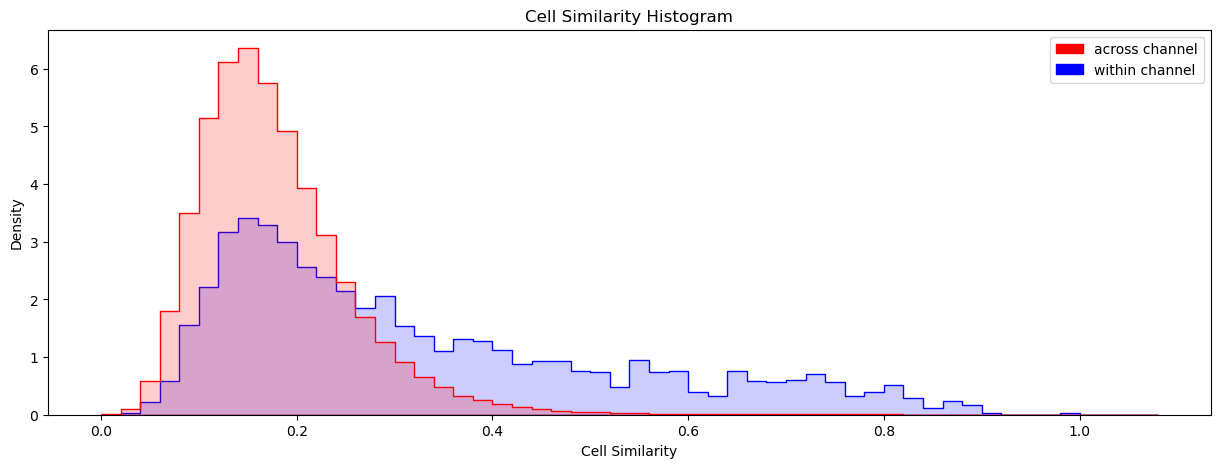

In [ ]:
# plot the histogram of cell distances
fig = plt.figure(figsize=(15,5))
#hist = np.histogram(across_channel_cell_dists, bins=np.arange(0, 1.1, 0.1), density=True)[0]
#plt.plot(np.arange(0, 1, 0.1), hist, linewidth=6, color='black')

dists = []
for dist in within_channel_cell_dists:
    dists.extend(dist)
    #plt.hist(dist, bins=np.arange(0, 1.1, 0.02), density=True, alpha=0.2, color='blue', align='left')
    #plt.plot(np.arange(0, 1, 0.1), hist, alpha=0.2, color='blue')
    #plt.fill_between(np.arange(0, 1, 0.1), hist, color='blue', alpha=0.1)

#plt.hist(dists, histtype='step', bins=np.arange(0, 1.1, 0.02), density=True, color='blue', align='left')
#plt.hist(across_channel_cell_dists, histtype='step', bins=np.arange(0, 1.1, 0.02), density=True, color='red', align='left')

# plot the two hists with sns step plot
sns.histplot(dists, bins=np.arange(0, 1.1, 0.02), stat='density', color='blue', alpha=0.2, element='step')
sns.histplot(across_channel_cell_dists, bins=np.arange(0, 1.1, 0.02), stat='density', color='red', alpha=0.2, element='step')

plt.xlabel('Cell Similarity')
plt.ylabel('Density')
plt.title('Cell Similarity Histogram')
plt.legend(['across channel', 'within channel'])
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')
plt.show()

100%|██████████| 92/92 [00:25<00:00,  3.66it/s]


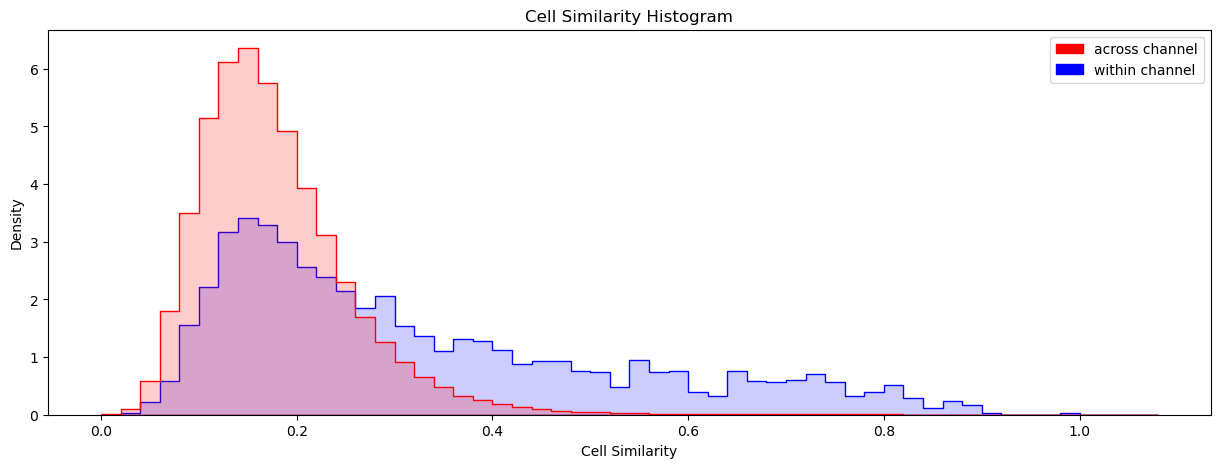

In [ ]:
mplt.plot_channel_similarities(channels)

# compare cells

In [ ]:
core = mplt.Core(model, expts, LLs)

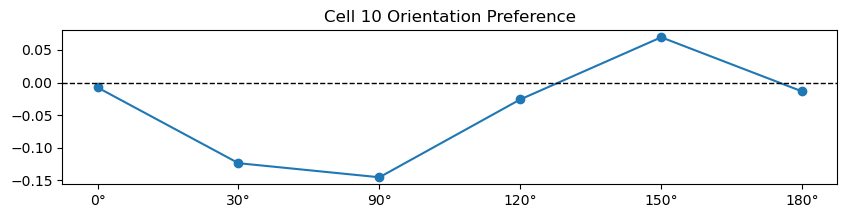

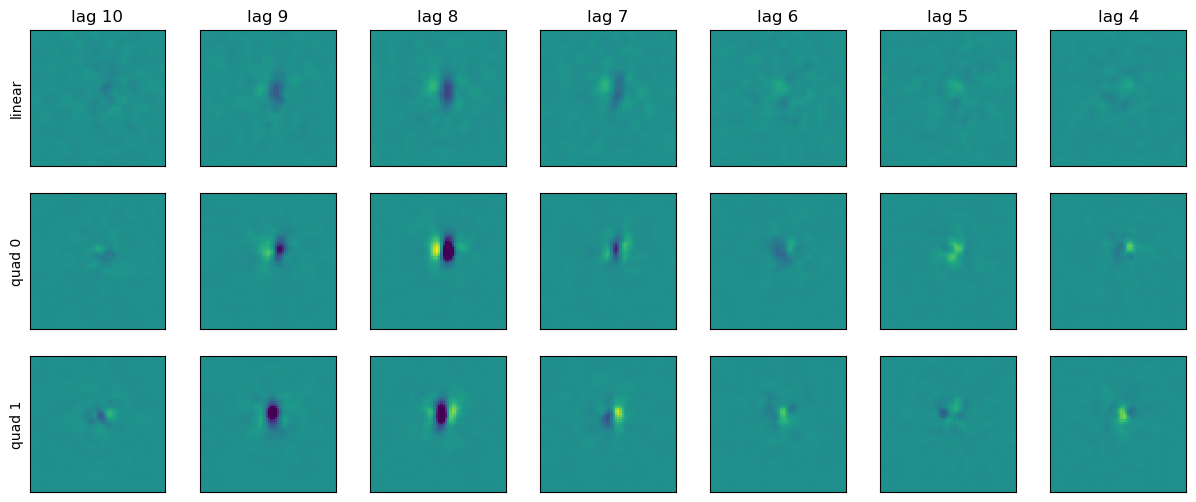

In [ ]:
core.cells[10].plot_ori_pref()
core.cells[10].plot_gqm()

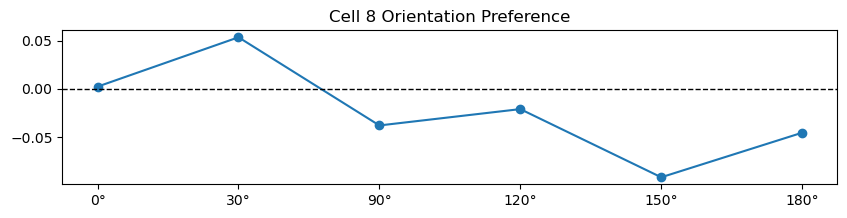

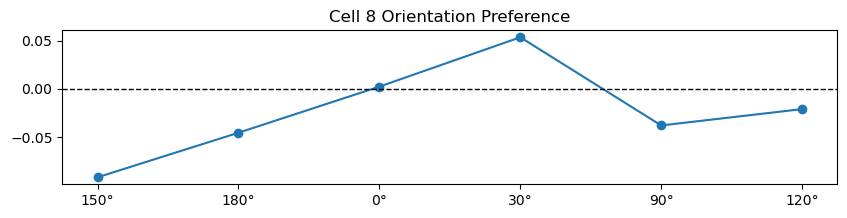

In [ ]:
core.cells[8].plot_ori_pref(shift=0)
core.cells[8].plot_ori_pref(shift=2)

0.005329696


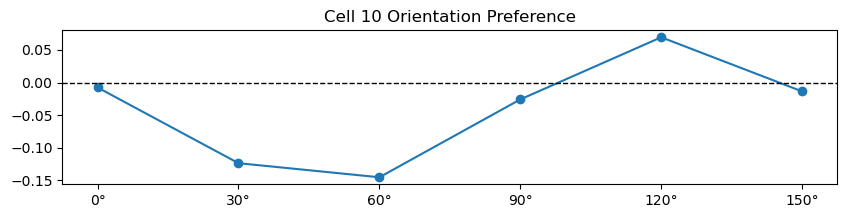

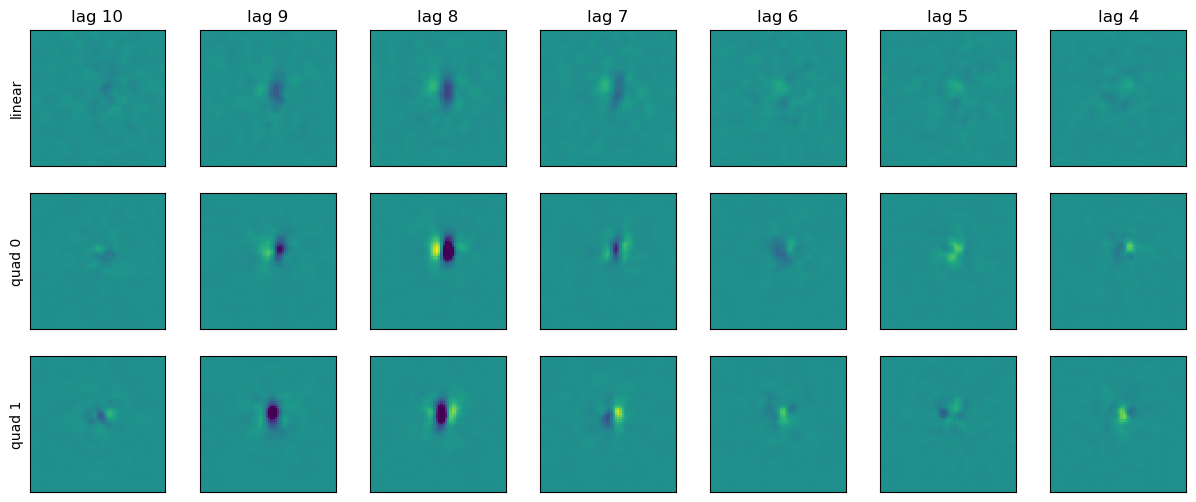

0.0019830281


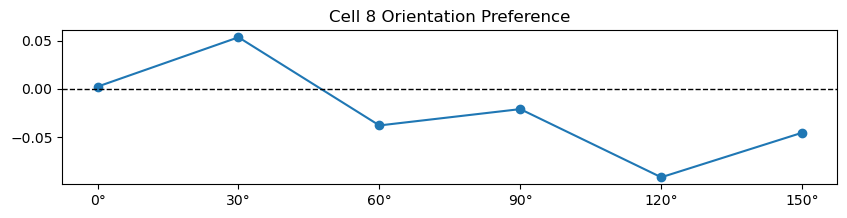

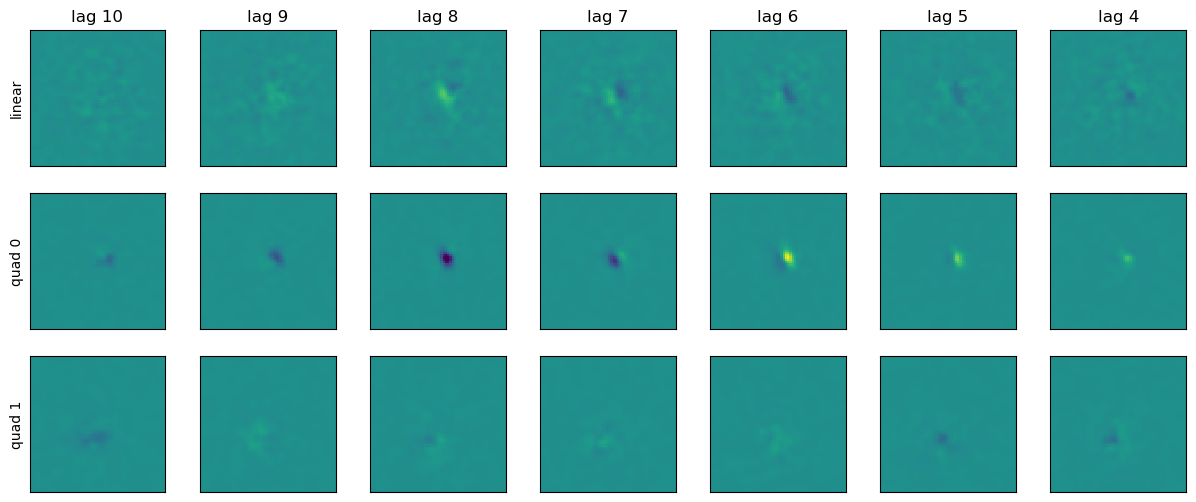

0.012325216


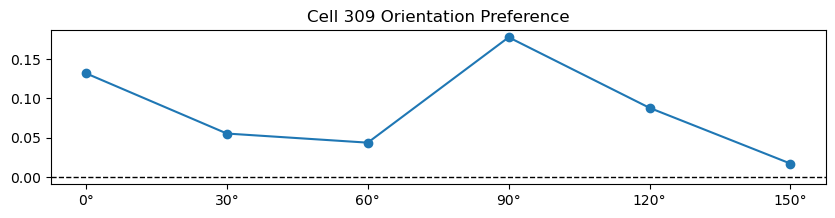

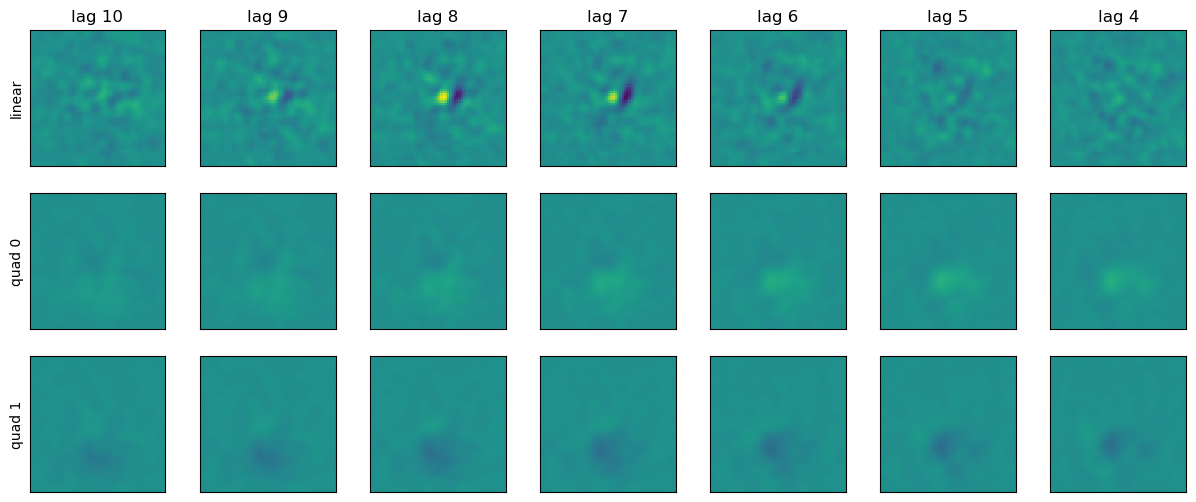

In [557]:
print(core.cells[10].ori_selectivity())
core.cells[10].plot_ori_pref()
core.cells[10].plot_gqm()
plt.show()
print(core.cells[8].ori_selectivity())
core.cells[8].plot_ori_pref()
core.cells[8].plot_gqm()
plt.show()

print(core.cells[1].ori_selectivity())
core.cells[309].plot_ori_pref()
core.cells[309].plot_gqm()
plt.show()

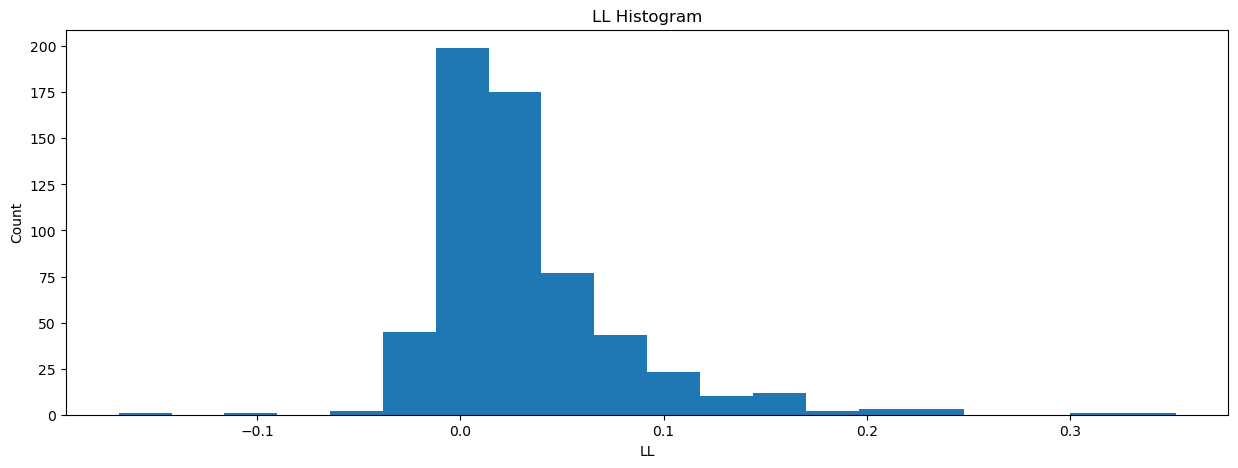

In [ ]:
core.plot_LLs()

100%|██████████| 92/92 [00:27<00:00,  3.38it/s]


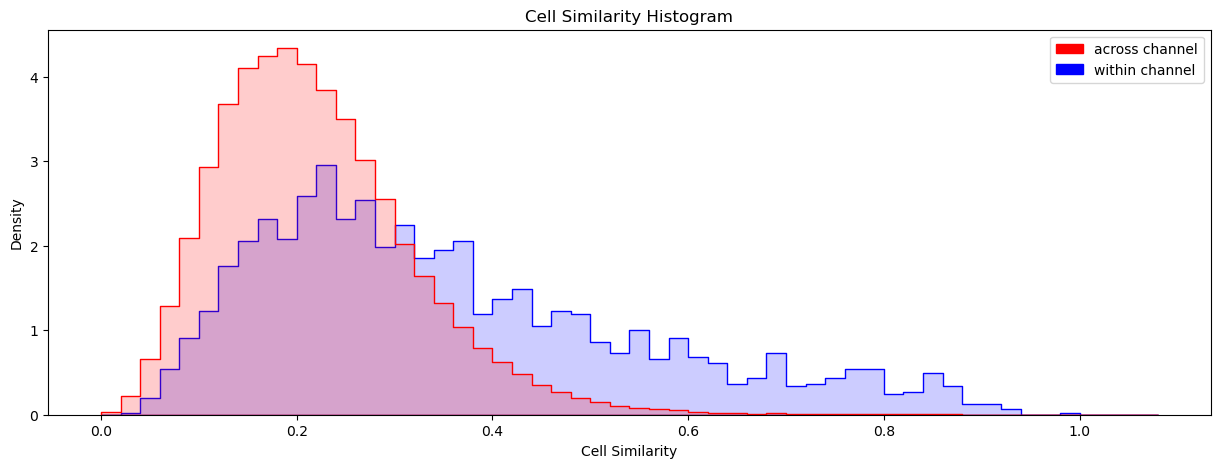

In [657]:
# core.plot_channel_similarities()
# core.plot_channel_similarities(exc=True)
# core.plot_channel_similarities(inh=True)
core.plot_channel_similarities(layer=0)

#core.cells[0].readout.by_orientation(orientation=0, layer=0)

#len(core.cells[0].readout.layers)
#print([layer.exc_weights[:, 0] for layer in core.cells[0].readout.layers if layer.orientation == 0 and layer.index == 0])
#core.cells[0].readout.by_orientation(orientation=0, layer=0, exc=True)

In [661]:
# compare cells with similar readouts, but with shifted orientations
cell_sims = core.get_all_cell_similarities(normalize=True)

100%|██████████| 598/598 [03:35<00:00,  2.77it/s]


In [667]:
# drop rows from the cell_sims dataframe where the LLA or LLB is less than 0.1
best_cell_sims = cell_sims[(cell_sims['LLA'] > 0.01) & (cell_sims['LLB'] > 0.01)]

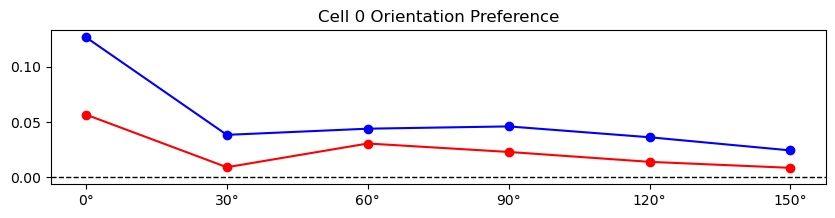

In [680]:
core.cells[0].plot_ori_pref(layer=0)

59904
201.142 --> 190.123 2.0 0.7945522665977478


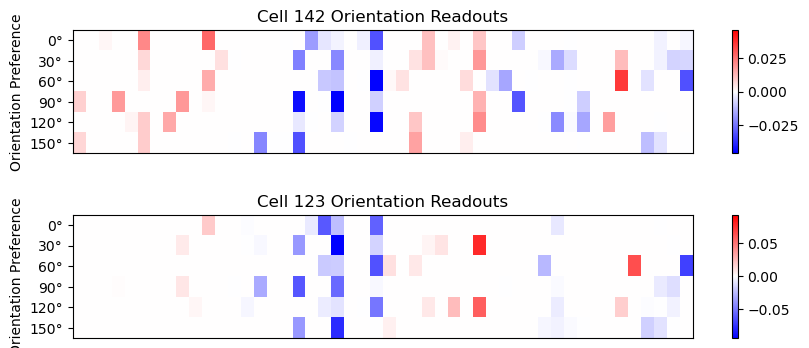

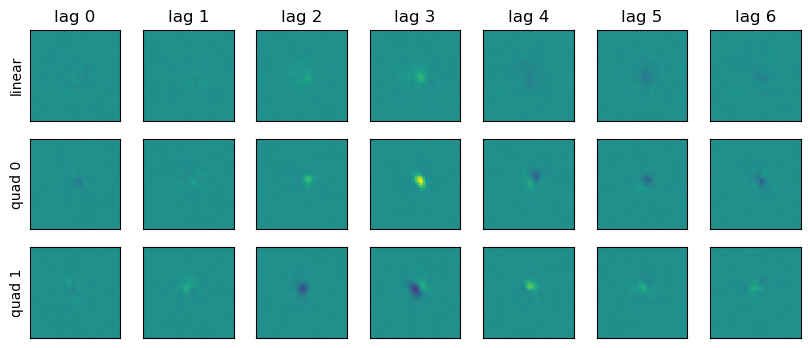

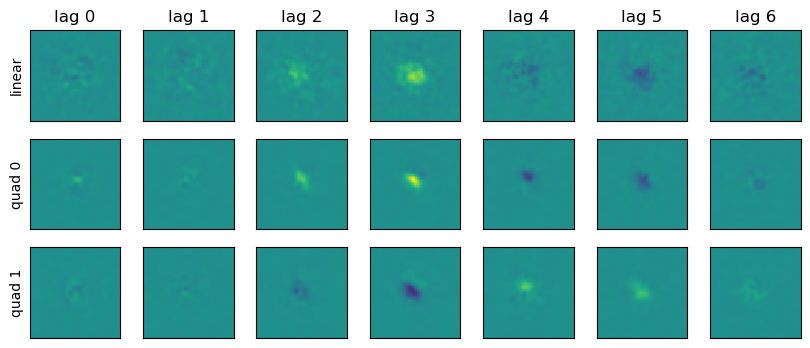

201.142 --> 190.137 -2.0 0.7697926759719849


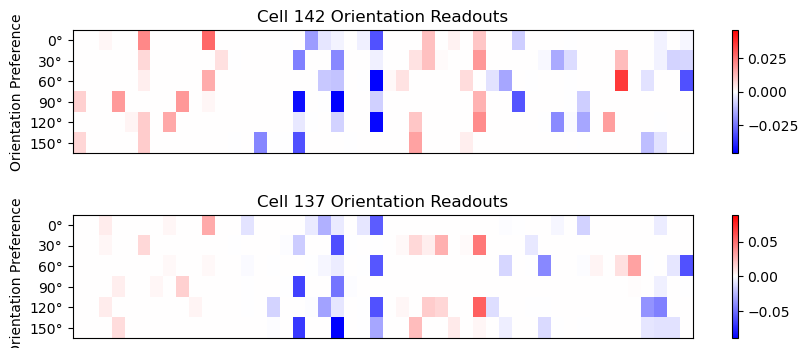

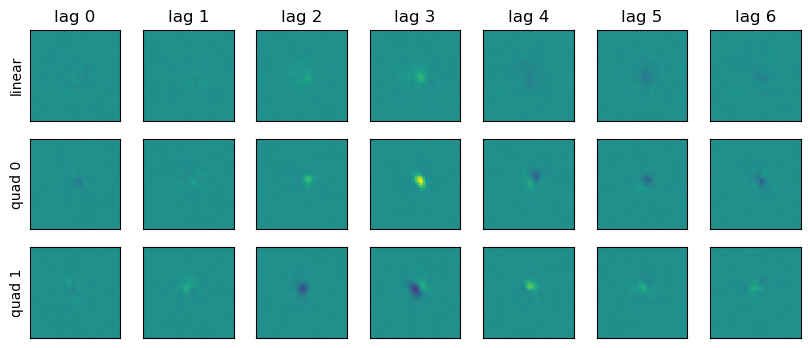

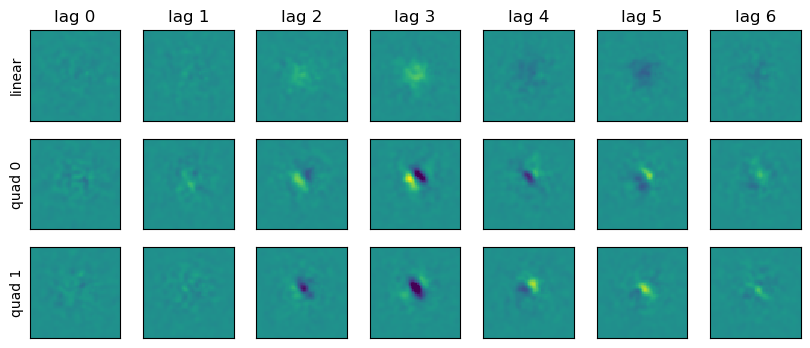

244.374 --> 188.189 -2.0 0.7676441073417664


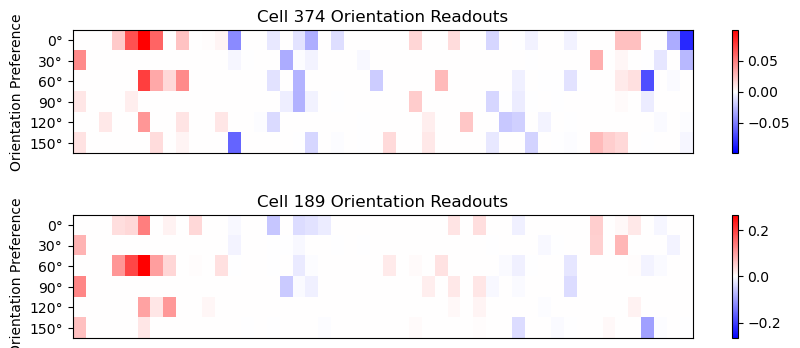

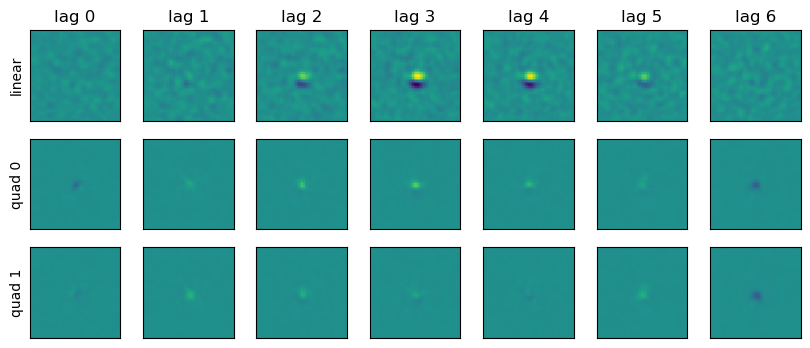

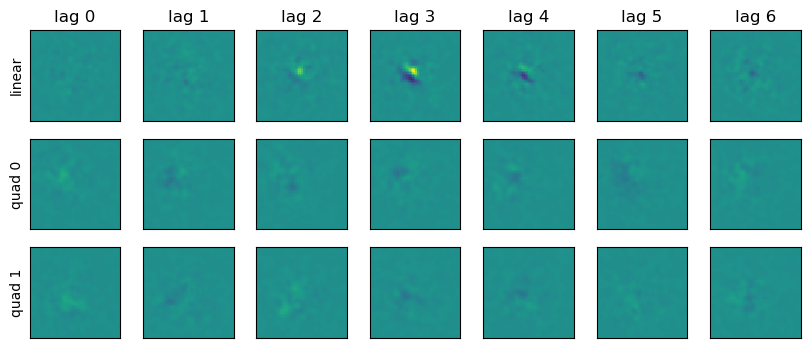

201.142 --> 190.126 -2.0 0.7566622495651245


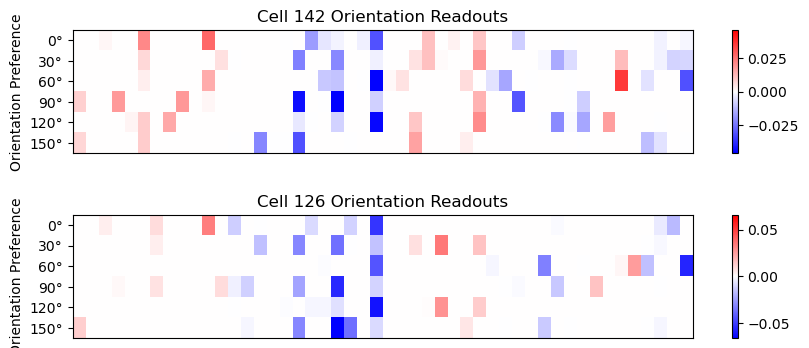

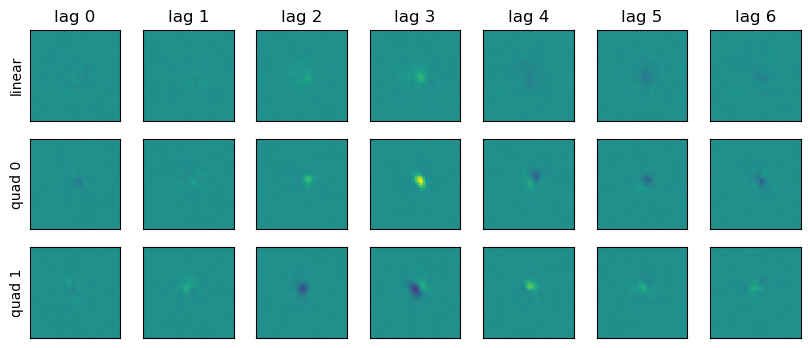

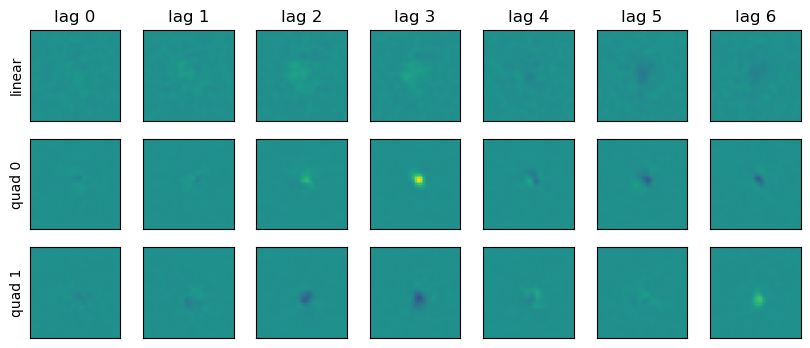

246.297 --> 245.93 2.0 0.7515561580657959


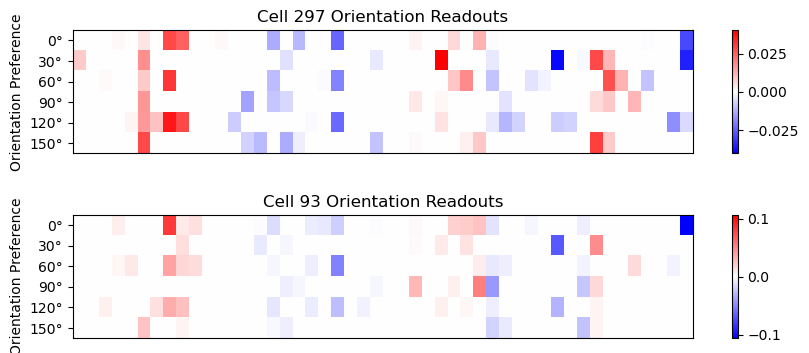

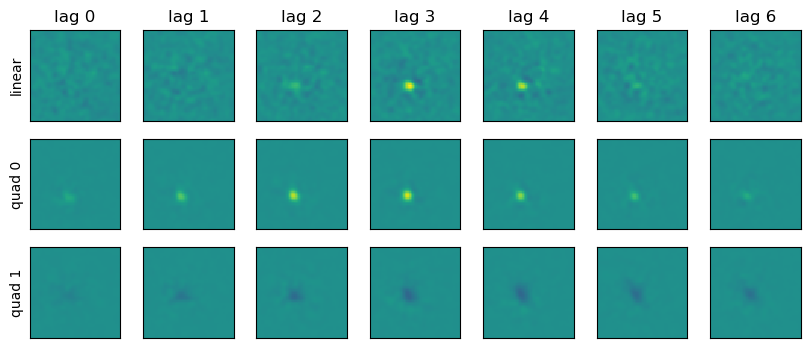

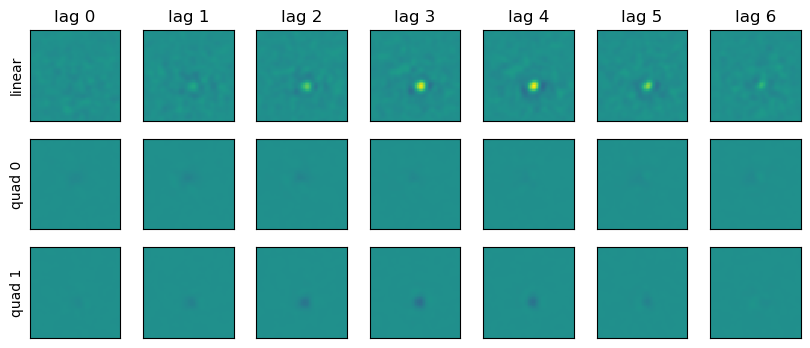

187.327 --> 188.189 -2.0 0.7452629208564758


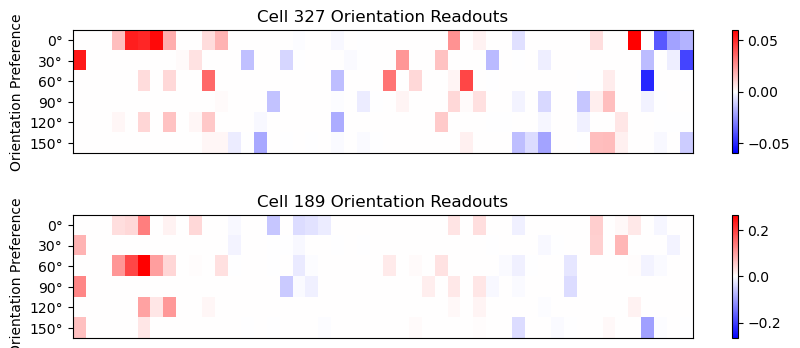

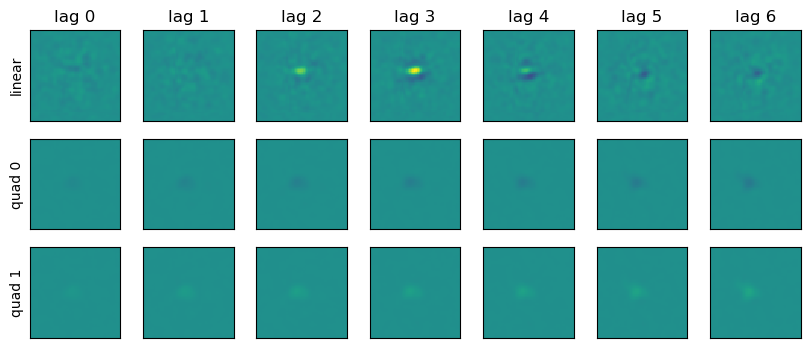

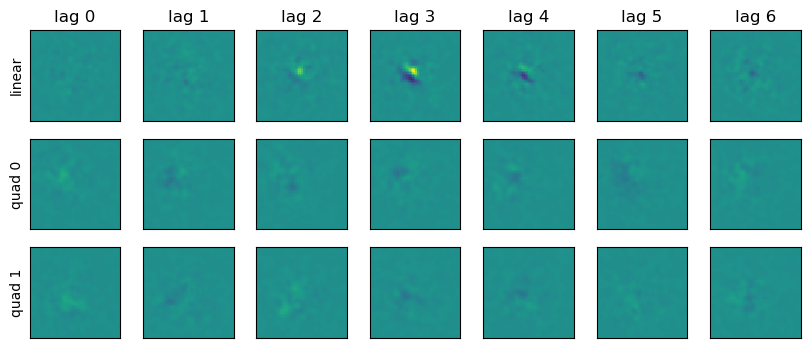

190.331 --> 201.142 2.0 0.7390583753585815


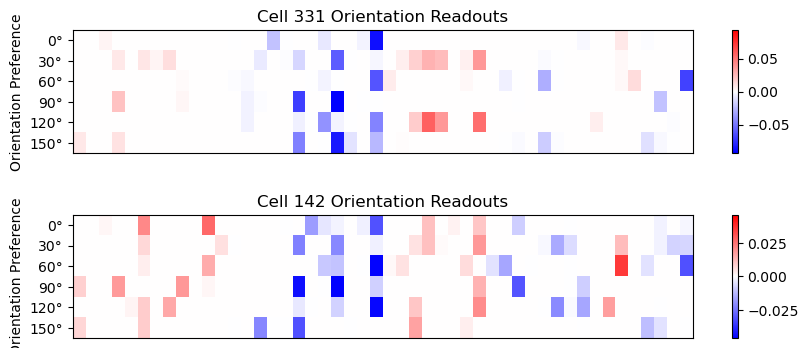

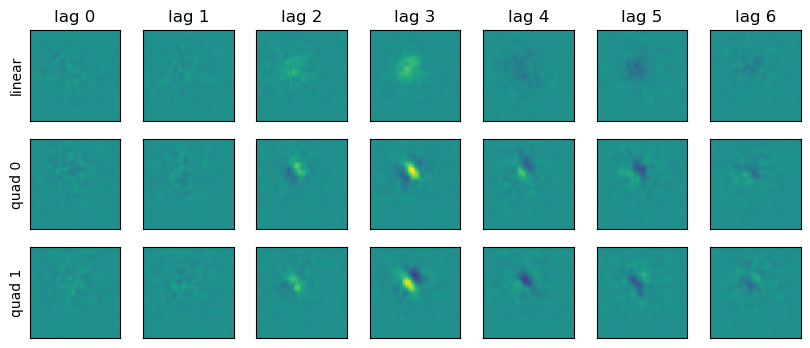

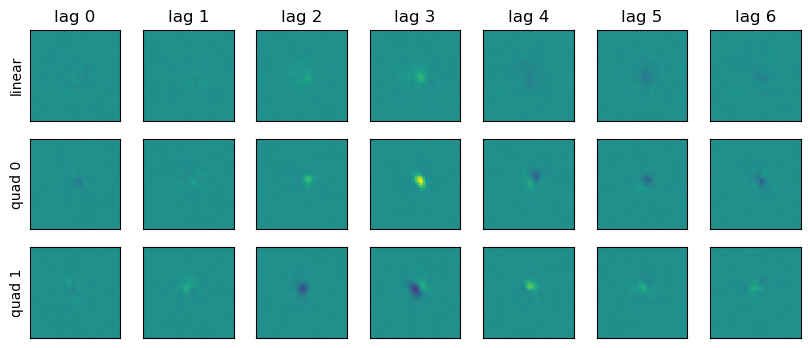

201.142 --> 190.125 -2.0 0.7380300760269165


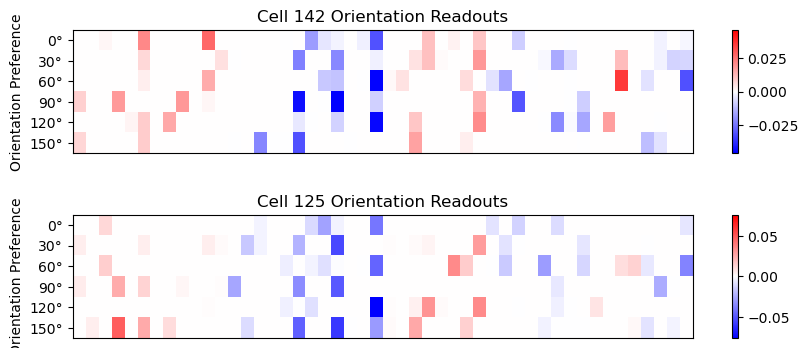

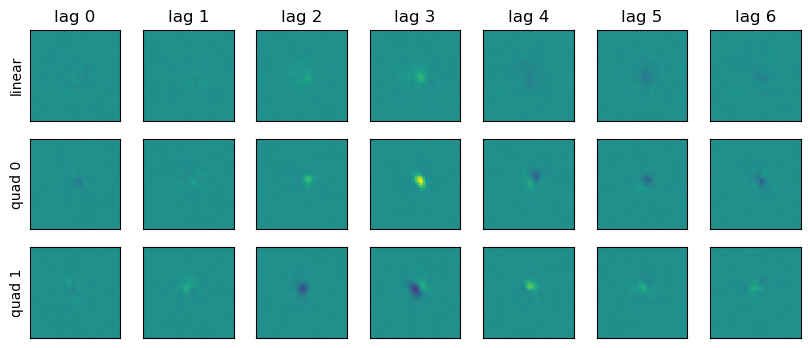

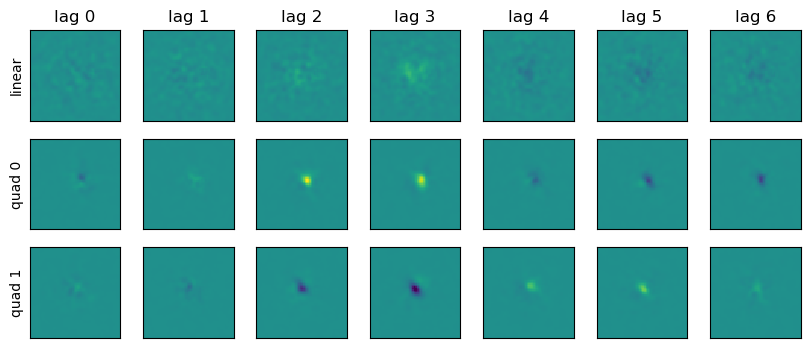

213.563 --> 199.408 -2.0 0.7308806777000427


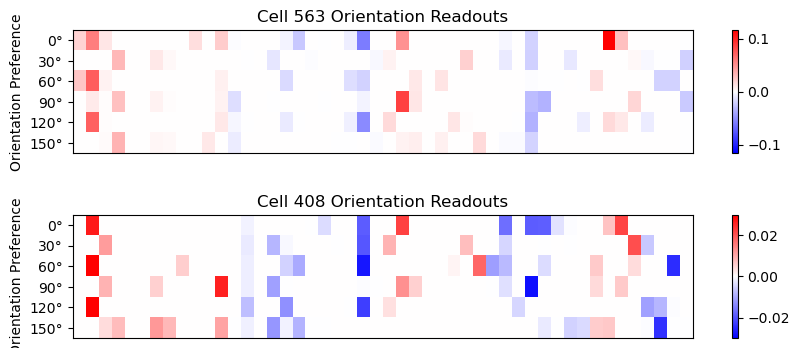

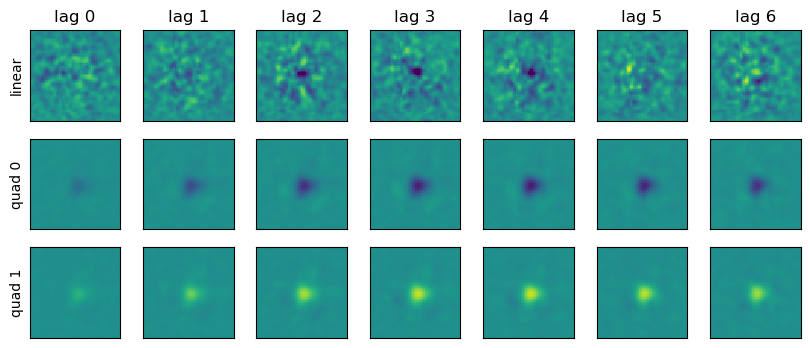

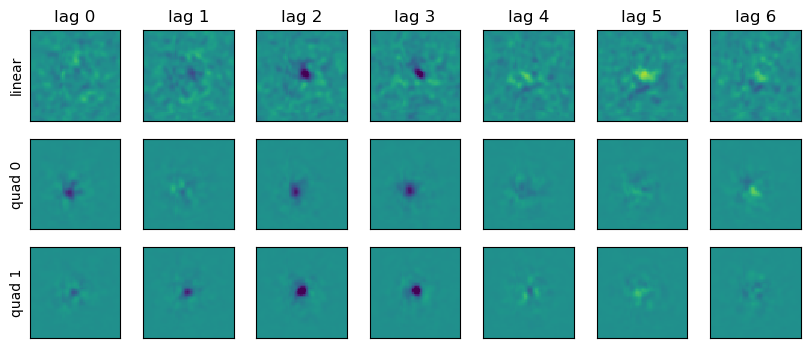

246.297 --> 202.30 -2.0 0.7214277386665344


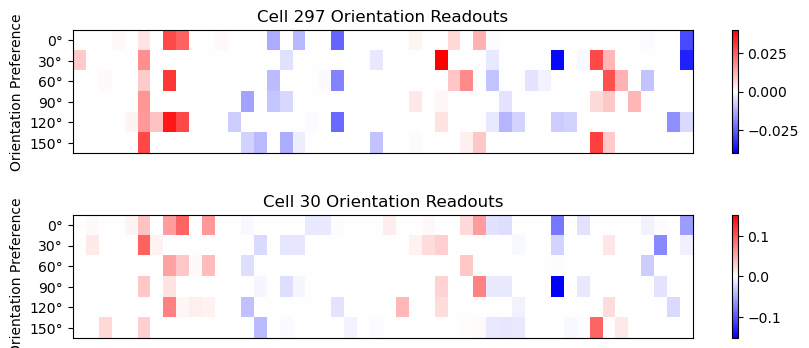

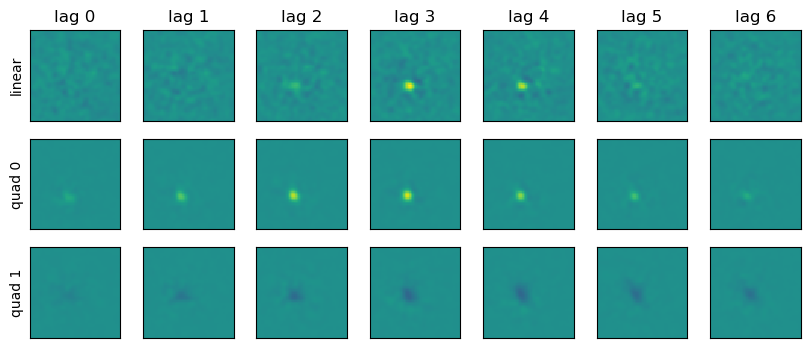

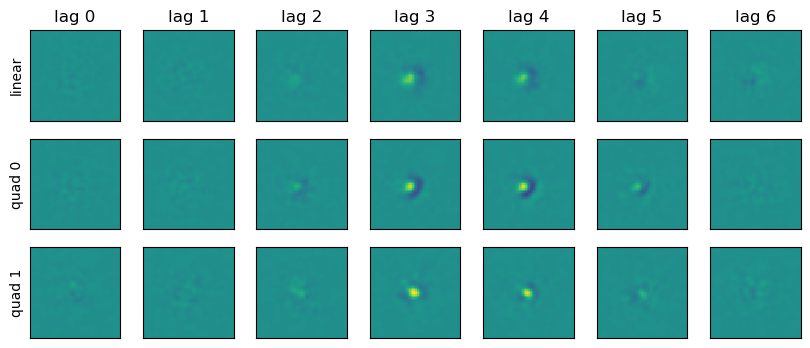

In [669]:
dist_key = 'layer0_dist'
shift_key = 'layer0_shift'

# sort cell_sims by the closest cells with the largest shifts, using pandas
sorted_cell_sims = pd.DataFrame(best_cell_sims).sort_values(by=[dist_key, shift_key], ascending=[False, False])
sorted_cell_sims = sorted_cell_sims[sorted_cell_sims[shift_key] != 0]

# drop rows where orisel is too low
sorted_cell_sims = sorted_cell_sims[(sorted_cell_sims['channelA'] != sorted_cell_sims['channelB'])]
#sorted_cell_sims = sorted_cell_sims[(sorted_cell_sims['oriselA'] > 0.02) & (sorted_cell_sims['oriselB'] > 0.02)]
# print the length of the sorted_cell_sims
print(len(sorted_cell_sims))

for i in range(10):
    row = sorted_cell_sims.iloc[i]
    print(str(int(row['channelA']))+'.'+str(int(row['cellA']))+' --> '+str(int(row['channelB']))+'.'+str(int(row['cellB'])),
          row[shift_key], row[dist_key])
    cellA = me.cells[int(row['cellA'])]
    cellB = me.cells[int(row['cellB'])]

    fig = plt.figure(figsize=(10,4))
    grid = matplotlib.gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)
    ax1 = plt.subplot(grid[0])
    cellA.plot_ori_readouts(ax=ax1, figsize=(6,2))
    ax2 = plt.subplot(grid[1])
    cellB.plot_ori_readouts(ax=ax2, figsize=(6,2)) #, shift=int(row['shift']
    cellA.plot_gqm(figsize=(10,4))
    cellB.plot_gqm(figsize=(10,4))
    plt.show()

In [543]:
readout_weights = mplt.get_readout_weights(model, group_orientations=True, layer_props=False)
print(readout_weights.shape)
laminar = mplt.Laminar(readout_weights, expts)

(288, 598)


92


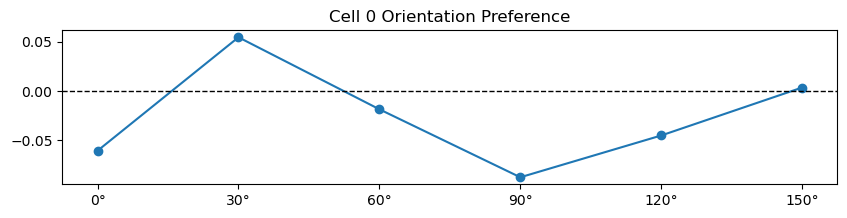

In [547]:
print(len(laminar.channels))
laminar.cells[0].plot_ori_pref()

In [ ]:
channel = channels[2]
# plot the orientation preferences for each cell in the channel
channel.plot_ori_prefs()
# get the first cell
cell = channel.cells[0]
# get the orientation preference for the cell
ori_pref = cell.ori_pref()
# plot the orientation preference for the cell
cell.plot_ori_pref()
# plot the readout weights for the cell as a matrix by orientation
cell.plot_ori_readouts()
# plot the sum readout weights for the cell as a bar chart by orientation
cell.plot_ori_readouts_bar()

# compare GQM ori and readout

In [ ]:
LLs[1], len(LLs)

In [ ]:
expt_names, expts.experiment_boundaries

# aggregate comparisons

In [ ]:
cell_to_gqm = {}
for expt_idx, (start,end) in enumerate(expts.experiment_boundaries):
    for ci, cell in enumerate(range(start, end)):
        if expt_idx == 0:
            fname = f'/Users/matt/projects/umd/gqms/J220715/UT{ci:03}gqmwET.pkl'
        elif expt_idx == 1:
            fname = f'/Users/matt/projects/umd/gqms/J220722/UT{ci:03}gqmwET.pkl'
        elif expt_idx == 2:
            fname = f'/Users/matt/projects/umd/gqms/J220707/UT{ci:03}gqmwET.pkl'
        # elif expt_idx == 3:
        #     fname = f'/Users/matt/projects/umd/gqms/J220801/UT{ci:03}gqmwET.pkl'
        with open(fname, 'rb') as f:
            gqm = pickle.load(f)
        cell_to_gqm[cell] = gqm

In [ ]:
readout_prefs = []
gqm_prefs = []
for cell in range(len(LLs)):
    if LLs[cell] < 0.001:
        continue
    if cell not in cell_to_gqm:
        continue
        
    prefs, max_readout_pref = ori_pref(cell)
    max_readout_pref = max_readout_pref*30

    gqm = cell_to_gqm[cell]
    max_dir_score, max_dir_score_angle, max_motion_im = RFutils.GQM_direction(gqm, lin_net=0, quad_net=2)
    max_gqm_pref = max_dir_score_angle
    
    # if GQM is greater than 180, we need to make it less than 180
    # if max_gqm_pref >= 180:
    #     max_gqm_pref -= 180
        
    readout_prefs.append(max_readout_pref)
    gqm_prefs.append(int(max_gqm_pref))

fig = plt.figure(figsize=(10,5))
plt.hist(gqm_prefs, alpha=0.5)
plt.hist(readout_prefs, alpha=0.5)
plt.show()

In [ ]:
len(readout_prefs), len(gqm_prefs)
readout_prefs[1], gqm_prefs[1]

In [ ]:
# plot the readout preferences vs the GQM preferences
fig = plt.figure(figsize=(5,5))
plt.plot(readout_prefs, gqm_prefs, 'o')
plt.xlabel('Readout Preference')
plt.ylabel('GQM Preference')
plt.title('Readout Preference vs GQM Preference')
plt.show()

In [ ]:
# cluster cells by orientation preferences (using UMAP)
import umap
import hdbscan

# get the orientation preferences for each cell
cell_orientation_preferences = []
orientation_preferences = []
for cell in cells:
    orientation_to_readout = cell.orientation_to_readout
    max_orientation = 0
    min_orientation = 0
    max_readout = 0
    min_readout = 0
    cell_orientation_preference = []
    for orientation in orientation_to_readout.keys():
        readout = orientation_to_readout[orientation]
        sum_readout = np.sum(readout)
        cell_orientation_preference.append(sum_readout)
        if sum_readout > max_readout:
            max_readout = sum_readout
            max_orientation = orientation
        if sum_readout < min_readout:
            min_readout = sum_readout
            min_orientation = -orientation
        # use the larger of the min and max orientation
        if np.abs(min_readout) > max_readout:
            max_orientation = min_orientation
            max_readout = min_readout
    orientation_preferences.append(max_orientation)
    cell_orientation_preferences.append(cell_orientation_preference)
    
# convert the list of cell orientation preferences to a numpy array
cell_orientation_preferences = np.array(cell_orientation_preferences)

plt.hist(orientation_preferences, bins=np.arange(-5,6)-0.5)
plt.show()

cell_orientation_preferences

In [ ]:
# get the UMAP embedding
embedding = umap.UMAP(n_neighbors=10, min_dist=0, metric='cosine').fit_transform(cell_orientation_preferences)

# cluster the embedding
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer.fit(embedding)

# plot the embedding
fig = plt.figure(figsize=(6,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=clusterer.labels_, cmap='tab20', s=5)
# plot legend
plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], loc='upper right', fontsize=8)
plt.show()

# plot some clustered cells

In [ ]:
def best_gqm_filter(gqm, lin_net=0, quad_net=2):
    linear = gqm.networks[lin_net].layers[0].get_weights()[:,:, :, 0]
    quad0 = gqm.networks[quad_net].layers[0].get_weights()[:,:, :, 0]
    quad1 = gqm.networks[quad_net].layers[0].get_weights()[:,:, :, 1]
    best_gqm_filter = None
    best_gqm_var = None
    for li, layer in enumerate([linear, quad0, quad1]):
        # get the lag with the clearest receptive field (highest variance)
        best_lag = RFutils.get_best_lag(layer)
        # get the GQM filter at the best lag
        gqm_filter = layer[:, :, best_lag]
        # get the variance of the GQM filter
        gqm_var = np.var(gqm_filter)
        if best_gqm_var is None or gqm_var > best_gqm_var:
            best_gqm_var = gqm_var
            best_gqm_filter = gqm_filter
    return best_gqm_filter

In [ ]:
plt.imshow(best_gqm_filter(cell_to_gqm[10]))

In [ ]:
# plot best lag for GQMs in a cluster
for cluster in range(14):
    cluster_cells = np.where(clusterer.labels_ == cluster)[0]
    
    gqms = [cell_to_gqm[cell] for cell in cluster_cells[:42]]
    vmax = np.max([np.max(best_gqm_filter(gqm)) for gqm in gqms])
    
    fig = plt.figure(figsize=(10,8))
    i = 0
    for cell in cluster_cells[:42]:
        if LLs[cell] < 0.01:
            continue
        max_ori_pref = np.abs(cell_orientation_preferences[cell]).argmax()
        # convert the orientation preference to an angle
        max_ori_pref_angle = max_ori_pref*30 * np.sign(cell_orientation_preferences[cell][max_ori_pref])
        gqm = gqms[i]
        plt.subplot(6, 7, i+1)
        plt.imshow(best_gqm_filter(gqm), vmin=-vmax, vmax=vmax)
        plt.title(f'Cell {cell}: {max_ori_pref_angle}°', fontsize=8)
        # turn off axis labels
        plt.xticks([])
        plt.yticks([])
        i += 1
    plt.suptitle(f'Cluster {cluster}', fontsize=16)
    plt.show()

# get orientation preference

In [ ]:
from skimage import measure
from skimage.feature import peak_local_max
from skimage import filters

def get_angle_between_points(x, y):
    # get the vector between the two peaks
    v = np.array([x[1]-x[0], y[1]-y[0]])
    # get the length of the vector
    v_len = np.sqrt(v[0]**2 + v[1]**2)
    # normalize the vector
    v = v / v_len
    # get the angle of the vector
    angle = np.arctan(v[1]/v[0])
    # convert to degrees
    angle = np.abs(angle * 180 / np.pi)
    return angle

def get_orientation(im):
    # get the FFT of the image at the current lag
    fftim2D = np.fft.fft2(im)
    fftim2D = np.fft.fftshift(fftim2D)
    fftim2D_abs = np.abs(fftim2D)

    # find the peaks in the image to find the direction of orientation
    smoothed_fftim = filters.gaussian(fftim2D_abs, sigma=6, truncate=0.1)
    peaks = peak_local_max(np.abs(smoothed_fftim), min_distance=2, threshold_rel=0.1)

    # if there are no peaks, then we can't measure the direction of motion
    if len(peaks) == 2:
        # get the x and y coordinates of the peaks
        x = peaks[:, 1]
        y = peaks[:, 0]
        angle = get_angle_between_points(x, y)
        return angle, peaks
    else:
        return None, None

# load a GQM

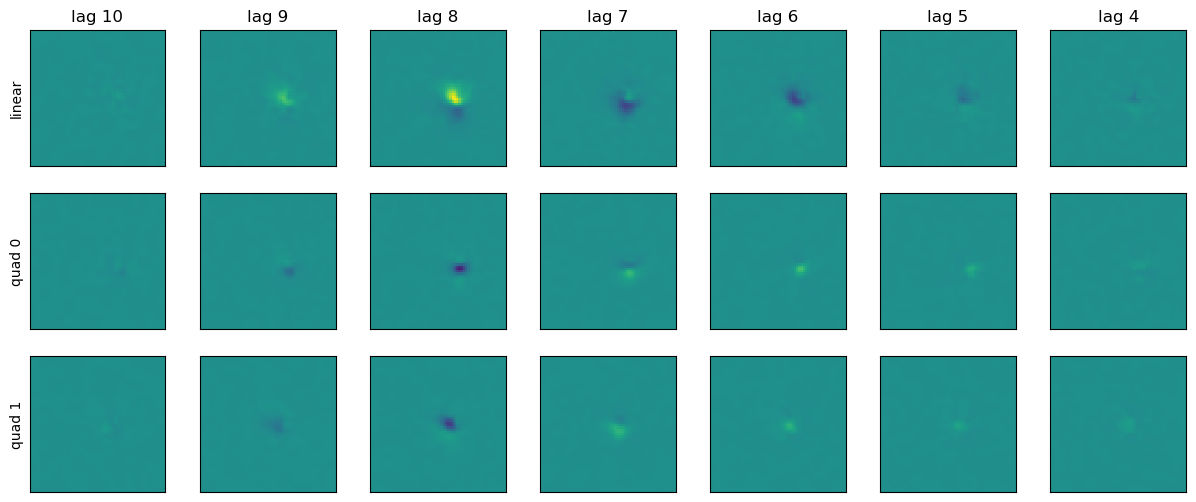

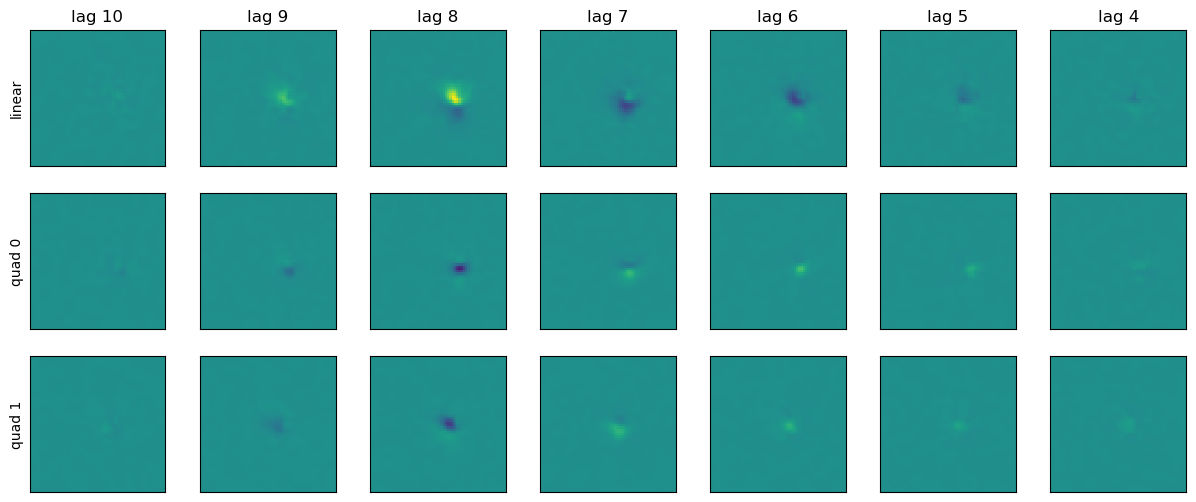

In [ ]:
fname = '/Users/matt/projects/umd/gqms/J220715/UT001gqmwET.pkl'
with open(fname, 'rb') as f:
    gqm = pickle.load(f)

mplt.plot_gqm(gqm)

me.cells[1].plot_gqm()

# plot readout 

In [ ]:
mplt.plot_readout_weights(model, group_orientations=True)

# OSI

In [ ]:
import scipy
# import filters
from scipy.ndimage import filters

def orientation_tuning_curves_mean(frequencies, inds, norms, angles, orientations, max_norm, min_norm):
    flattened_freq=frequencies.flatten()
    mean_responses=[]
    epsilon=(orientations[1]-orientations[0])/2
    for k in range(len(orientations)):
        theta=orientations[k]
        integrands=[]
        for j in range(len(angles)):
            angle=np.abs(angles[j])
            if norms[j]>max_norm or norms[j]<min_norm:
                continue
            else:
                if theta-epsilon<angle<theta+epsilon or theta-epsilon<angle+2*np.pi<theta+epsilon:
                    integrands.append(flattened_freq[j])
                else:
                    continue
        mean_responses.append(np.mean(integrands))
    OSI_mean=(np.max(mean_responses)-np.min(mean_responses))/(np.max(mean_responses)+np.min(mean_responses))
    return mean_responses, OSI_mean

def grid_center_angles_and_norms(N):
    if N%2==0:
        grid_x_pos = np.repeat((np.linspace(-(N-1), N-1, N)), N)
        grid_y_pos = np.tile((np.linspace(-(N-1), N-1, N)), N)
    if N%2==1:
        grid_x_pos = np.tile(np.linspace(-np.floor(N/2), np.floor(N/2), N), N)
        grid_y_pos =np.tile(np.linspace(-np.floor(N/2), np.floor(N/2), N), N)
    center_angles=[]
    norms=[]
    for i in range(len(grid_y_pos)):
        norms.append(scipy.linalg.norm(np.array([grid_x_pos[i]/2, grid_y_pos[i]/2])))
        base_angle=np.arctan2(grid_y_pos[i], grid_x_pos[i])
        center_angles.append(base_angle)
    return center_angles, norms

def binned_norms(norms, bin_size):
    sorted_norm_inds=np.argsort(norms)
    counts, bins=np.histogram(norms, bin_size)
    inds=np.insert(np.cumsum(counts), 0, 0)
    return inds, bins

def norm_truncation(norms, threshold):
    sorted_norm_inds=np.argsort(norms)
    sorted_norms=np.asarray(norms)[sorted_norm_inds]
    cutoff=np.max(np.nonzero(sorted_norms<threshold*np.ones(len(sorted_norms))))
    valid_norms=sorted_norms[0:cutoff]
    return valid_norms

def combined_GQM_fourier_transform(gqm, scale, best_lag):
    assert len(scale)==1 or len(scale)==3, "Weights must have length 1 or 3"
    w0=gqm.get_weights(ffnet_target=0).reshape(60, 60, -1)
    w1=gqm.get_weights(ffnet_target=2)[:, :, :, 0].reshape(60, 60, -1)
    w2=gqm.get_weights(ffnet_target=2)[:, :, :, 1].reshape(60, 60, -1)
    weightlist=[w0, w1, w2]
    fft_list=[]
    for j in range(3):
        im=weightlist[j][:, :, -best_lag].T #Why is this getting transposed? 
        fftim2D = np.fft.fft2(im)
        fftim2D= np.fft.fftshift(fftim2D)
        fftim2D_abs = np.abs(fftim2D)
        smoothed_fftim = filters.gaussian(fftim2D_abs, sigma=10, truncate=1/5)
        fft_list.append(smoothed_fftim)
    if len(scale)==1:
        summed_fft=(1-scale)*fft_list[0]+0.5*scale*(fft_list[1]+fft_list[2])
    else:
        summed_fft=scale[0]*fft_list[0]+scale[1]*fft_list[1]+scale[2]*fft_list[2]
    return summed_fft #I guess we'll keep these guys around in here too.

def get_frequency_tuning_curve(inds, frequencies, norms):
    flattened_freq=frequencies.flatten()
    sorted_norm_inds=np.argsort(norms)
    frequency_tuning_curve=[]
    for j in range(len(inds)-1):
        indices=sorted_norm_inds[inds[j]:inds[j+1]]
        frequency_tuning_curve.append(np.mean(flattened_freq[indices])) #Oh. Okay, that's why it blows up. 
    return frequency_tuning_curve

summed_ffts = []
summed_fft = combined_GQM_fourier_transform(
    core_gqm, filter_weights, best_lag)
summed_ffts.append(summed_fft)

frequency_tuning_curve = get_frequency_tuning_curve(
    finer_inds, summed_fft, valid_norms)

orientation_tuning_curve, OSI = orientation_tuning_curves_mean(
    summed_fft, inds, norms, center_angles, 
    orientations, finer_bins[-2], finer_bins[1])

